# EcoDRR — DRR Advanced Modeling
This notebook implements DEM-based flood proxies, Curve Number runoff modeling, NDVI change detection, habitat quality proxy, and risk fusion. It expects exported rasters in `/content/data/`.

In [ ]:
!pip install rasterio

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import sobel, gaussian_filter
print('Libraries loaded')

Libraries loaded


## 1. Paths & quick checks
Make sure these files exist in `/mnt/data`:
- dem.tif
- chirps.tif (24h or aggregated)
- ndvi_recent.tif
- ndvi_hist.tif
- landcover_unet.tif (1=veg,2=bare,3=built)

The notebook will stop gracefully and explain how to export if files missing.

In [3]:
base_paths = {
    'dem':'/content/data/dem_export.tif',
    'chirps':'/content/data/chirps_export.tif',
    'ndvi_recent':'/content/data/ndvi_recent_export.tif',
    'ndvi_hist':'/content/data/ndvi_hist_export.tif',
    'landcover':'/content/data/landcover_unet.tif'
}
for k,p in base_paths.items():
    print(k, '->', p, os.path.exists(p))


dem -> /content/data/dem_export.tif True
chirps -> /content/data/chirps_export.tif True
ndvi_recent -> /content/data/ndvi_recent_export.tif True
ndvi_hist -> /content/data/ndvi_hist_export.tif True
landcover -> /content/data/landcover_unet.tif True


## 2. Utility functions: load raster, write raster, safe slope computation

In [4]:
def load_raster(path, band=1):
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    with rasterio.open(path) as src:
        arr = src.read(band)
        meta = src.meta.copy()
    return arr, meta

def write_raster(path, arr, meta):
    meta2 = meta.copy()
    meta2.update({'count':1, 'dtype':str(arr.dtype)})
    with rasterio.open(path, 'w', **meta2) as dst:
        dst.write(arr, 1)

from scipy.ndimage import sobel, gaussian_filter

def compute_safe_slope(dem):
    demf = dem.astype(float)
    demf = np.where(np.isfinite(demf), demf, np.nan)
    demf = np.nan_to_num(demf, nan=np.nanmean(demf))
    sx = sobel(demf, axis=1)
    sy = sobel(demf, axis=0)
    slope = np.sqrt(sx**2 + sy**2)
    slope = np.nan_to_num(slope, nan=0.0, posinf=0.0, neginf=0.0)
    slope = gaussian_filter(slope, sigma=1)
    return slope

print('Utility functions defined')

Utility functions defined


## 3. DEM-based flood proxy
Compute slope, local depression proxy and combine into a flood susceptibility raster.

In [6]:
try:
    dem, dem_meta = load_raster(base_paths['dem'])
    print('DEM loaded', dem.shape)
    slope = compute_safe_slope(dem)
    dem_mean = np.nanmean(dem)
    dem_diff = dem.astype(float) - dem_mean
    depression_mask = (dem_diff < 0).astype(float)
    flood_proxy = depression_mask * (1.0 / (slope + 1e-6))
    flood_proxy = gaussian_filter(flood_proxy, sigma=1)
    # Normalize 0-1
    flood_proxy = (flood_proxy - np.nanmin(flood_proxy)) / (np.nanmax(flood_proxy)-np.nanmin(flood_proxy)+1e-9)
    print('Flood proxy computed')
    # write
    out_fp = '/content/data/flood_proxy.tif'
    dem_meta.update({'dtype':'float32'})
    write_raster(out_fp, flood_proxy.astype('float32'), dem_meta)
    print('Saved flood proxy to', out_fp)
except FileNotFoundError as e:
    print('Missing DEM: please export dem.tif from GEE. Error:', e)
except Exception as e:
    print('Error computing flood proxy:', e)


DEM loaded (151, 150)
Flood proxy computed
Saved flood proxy to /content/data/flood_proxy.tif


## 4. Curve Number (CN) Runoff Model
Uses CHIRPS rainfall raster and landcover classes to compute runoff depth (mm).

In [10]:
def compute_runoff_from_cn(P, CN):
    S = (25400.0 / (CN + 1e-9)) - 254.0
    Ia = 0.2 * S
    R = np.zeros_like(P, dtype=float)
    mask = P > Ia
    R[mask] = ((P[mask] - Ia[mask])**2) / (P[mask] + 0.8 * S[mask])
    return R

# ---- FIX: RESAMPLE CHIRPS TO MATCH LANDCOVER ----
def resample_to_ref(arr, arr_meta, ref_meta, method=Resampling.bilinear):
    """Resample arr to match ref_meta (landcover resolution)."""
    with rasterio.open(arr_meta['path']) as src:
        data = src.read(
            out_shape=(1, ref_meta['height'], ref_meta['width']),
            resampling=method
        )[0]
    return data

try:
    # Load rainfall + landcover
    rain, rain_meta = load_raster(base_paths['chirps'])
    lc, lc_meta = load_raster(base_paths['landcover'])

    print("Original shapes:", rain.shape, lc.shape)

    # Patch meta for resampling
    rain_meta['path'] = base_paths['chirps']

    # ---- RESAMPLE RAINFALL ----
    rain_resampled = resample_to_ref(rain, rain_meta, lc_meta)
    print("Resampled rainfall:", rain_resampled.shape)

    # ---- CN LOOKUP ----
    cn_lookup = {1: 55, 2: 75, 3: 90}
    CN = np.zeros_like(lc, dtype=float)
    for k, v in cn_lookup.items():
        CN[lc == k] = v

    # ---- RUNOFF ----
    runoff = compute_runoff_from_cn(rain_resampled, CN)

    # Normalize
    runoff_norm = (runoff - np.nanmin(runoff)) / (np.nanmax(runoff) - np.nanmin(runoff) + 1e-9)

    # Save output
    out_rf = "/content/data/runoff_map.tif"
    lc_meta.update({'dtype': 'float32'})
    write_raster(out_rf, runoff.astype("float32"), lc_meta)

    print("Runoff map saved to", out_rf)

except Exception as e:
    print("Error computing corrected CN runoff:", e)

Original shapes: (2, 2) (128, 128)
Resampled rainfall: (128, 128)
Runoff map saved to /content/data/runoff_map.tif


## 5. NDVI Change Detection (ΔNDVI)
Compute NDVI delta between historical and recent NDVI rasters and save output.

In [11]:
try:
    ndvi_r, ndvi_r_meta = load_raster(base_paths['ndvi_recent'])
    ndvi_h, ndvi_h_meta = load_raster(base_paths['ndvi_hist'])
    ndvi_delta = ndvi_r.astype(float) - ndvi_h.astype(float)
    out_ndvi_delta = '/content/data/ndvi_delta.tif'
    ndvi_r_meta.update({'dtype':'float32'})
    write_raster(out_ndvi_delta, ndvi_delta.astype('float32'), ndvi_r_meta)
    print('NDVI delta saved to', out_ndvi_delta)
except FileNotFoundError as e:
    print('Missing NDVI rasters. Error:', e)
except Exception as e:
    print('Error computing NDVI delta:', e)


NDVI delta saved to /content/data/ndvi_delta.tif


## 6. Habitat quality proxy (NDVI-based)
Simple normalization of recent NDVI to [0,1] as habitat quality estimate.

In [12]:
try:
    ndvi_r, ndvi_r_meta = load_raster(base_paths['ndvi_recent'])
    hq = np.clip((ndvi_r - np.nanmin(ndvi_r)) / (np.nanmax(ndvi_r)-np.nanmin(ndvi_r)+1e-9), 0,1)
    out_hq = '/content/data/habitat_quality.tif'
    ndvi_r_meta.update({'dtype':'float32'})
    write_raster(out_hq, hq.astype('float32'), ndvi_r_meta)
    print('Habitat quality saved to', out_hq)
except Exception as e:
    print('Habitat quality error:', e)


Habitat quality saved to /content/data/habitat_quality.tif


## 7. Risk Fusion
Combine flood proxy, runoff, exposure (built-up), vulnerability (NDVI loss), and ecosystem services (habitat quality).

In [15]:
from rasterio.enums import Resampling

# Utility resample function
def resample_to_ref(arr_path, ref_meta):
    with rasterio.open(arr_path) as src:
        data = src.read(
            out_shape=(1, ref_meta['height'], ref_meta['width']),
            resampling=Resampling.bilinear
        )[0]
    return data

try:
    # Load reference raster (landcover)
    lc, lc_meta = load_raster(base_paths['landcover'])
    H_ref, W_ref = lc.shape
    print("Reference landcover grid:", lc.shape)

    # Resample all other rasters to landcover grid
    flood = resample_to_ref("/content/data/flood_proxy.tif", lc_meta)
    runoff = resample_to_ref("/content/data/runoff_map.tif", lc_meta)
    ndvi_delta = resample_to_ref("/content/data/ndvi_delta.tif", lc_meta)
    hq = resample_to_ref("/content/data/habitat_quality.tif", lc_meta)

    # Print shapes to confirm alignment
    print("Shapes after resampling:")
    print("flood:", flood.shape)
    print("runoff:", runoff.shape)
    print("ndvi_delta:", ndvi_delta.shape)
    print("habitat_quality:", hq.shape)

    # Normalize hazard components
    flood_n = (flood - flood.min()) / (flood.max() - flood.min() + 1e-9)
    runoff_n = (runoff - runoff.min()) / (runoff.max() - runoff.min() + 1e-9)
    H = (flood_n + runoff_n) / 2.0

    # Exposure from landcover
    Exposure = (lc == 3).astype(float)

    # Vulnerability from NDVI loss
    Vulnerability = (ndvi_delta < -0.05).astype(float)

    # Ecosystem services = habitat quality (0–1)
    ES = (hq - hq.min()) / (hq.max() - hq.min() + 1e-9)

    # Final risk fusion model
    Risk = H * Exposure * (1.0 + Vulnerability) * (1.0 - ES)

    Risk = (Risk - Risk.min()) / (Risk.max() - Risk.min() + 1e-9)

    # Save output
    out_risk = "/content/data/drr_risk_map.tif"
    lc_meta.update({"dtype": "float32", "count": 1})

    with rasterio.open(out_risk, "w", **lc_meta) as dst:
        dst.write(Risk.astype("float32"), 1)

    print("DRR Risk map saved to", out_risk)

except Exception as e:
    print("Error creating risk map:", e)

Reference landcover grid: (128, 128)
Shapes after resampling:
flood: (128, 128)
runoff: (128, 128)
ndvi_delta: (128, 128)
habitat_quality: (128, 128)
DRR Risk map saved to /content/data/drr_risk_map.tif


## 8. Visualizations
Plot the key rasters (if available) for quick interpretation.

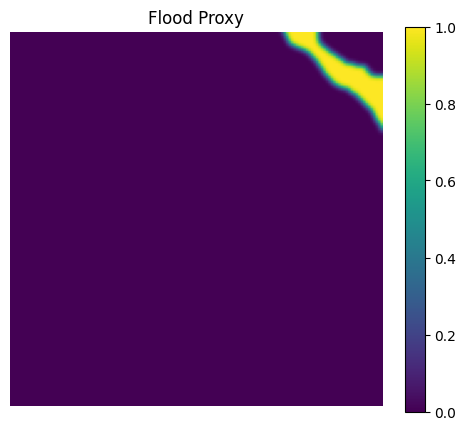

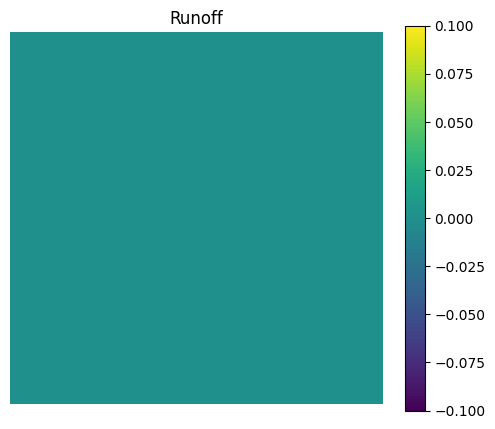

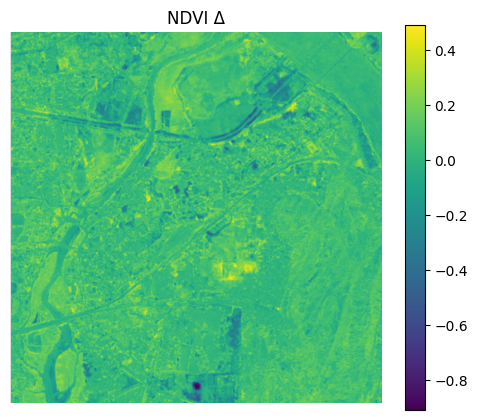

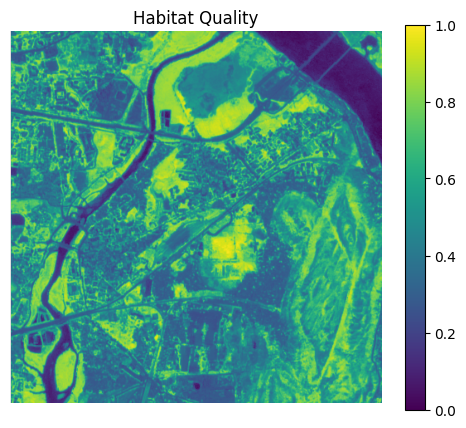

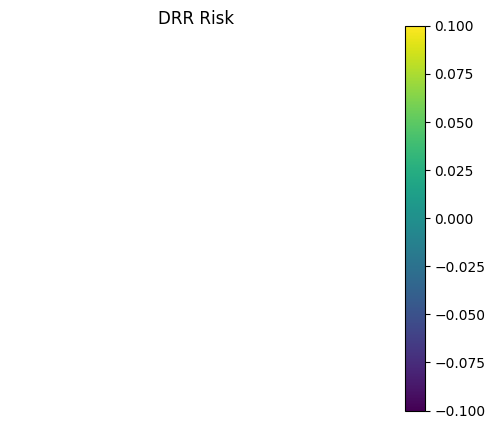

In [16]:
def plot_arr(arr, title=''):
    plt.figure(figsize=(6,5)); plt.imshow(arr, cmap='viridis'); plt.title(title); plt.colorbar(); plt.axis('off')

for p, name in [('/content/data/flood_proxy.tif','Flood Proxy'), ('/content/data/runoff_map.tif','Runoff'), ('/content/data/ndvi_delta.tif','NDVI Δ'), ('/content/data/habitat_quality.tif','Habitat Quality'), ('/content/data/drr_risk_map.tif','DRR Risk')]:
    if os.path.exists(p):
        arr, _ = load_raster(p)
        plot_arr(arr, name)
    else:
        print('Missing', p)


### End of Advanced Modeling notebook. Interpretations:
- Flood Proxy: high values indicate depressions and low slope where water accumulates.
- Runoff: high values (mm) indicate surfaces contributing to quick surface flow.
- NDVI Δ: negative values indicate vegetation loss — higher vulnerability.
- Habitat Quality: normalized NDVI, higher is better.
- DRR Risk: combined index; higher values are priorities for NbS interventions.